<a href="https://colab.research.google.com/github/thecrazyphysicist369/machine-learning-assignement/blob/main/7_em.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Apply EM algorithm to cluster a set of data stored in a .CSV file. Use the same data set for
clustering using k-Means algorithm. Compare the results of these two algorithms and
comment on the quality of clustering.

In [2]:
#Cloning the repository for dataset
!git clone https://github.com/thecrazyphysicist369/machine-learning-assignement

Cloning into 'machine-learning-assignement'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 187 (delta 102), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (187/187), 678.49 KiB | 3.31 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [48]:
#importing all the libraries
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt

In [9]:
#importing the dataset
data = pd.read_csv('/content/machine-learning-assignement/datasets/banknote.csv',
                   dtype = {'A' : 'float',
                            'B' : 'float',
                            'C' : 'float',
                            'D' : 'float',
                            'Y' : 'float'})

In [10]:
data

,A,B,C,D,Y
0,3.62160,8.66610,-2.8073,-0.44699,0.0
1,4.54590,8.16740,-2.4586,-1.46210,0.0
2,3.86600,-2.63830,1.9242,0.10645,0.0
3,3.45660,9.52280,-4.0112,-3.59440,0.0
4,0.32924,-4.45520,4.5718,-0.98880,0.0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1.0
1368,-1.38870,-4.87730,6.4774,0.34179,1.0
1369,-3.75030,-13.45860,17.5932,-2.77710,1.0
1370,-3.56370,-8.38270,12.3930,-1.28230,1.0


In [17]:
#Splitting the data into
#features
x_labeled = data[['A', 'B', 'C', 'D']].values

#labels
y_labeled = data['Y'].values

In [40]:
#the expectation step
def e_step(x, params):
    np.log([multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)])
    log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                np.log([multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])

In [31]:
#the maximisation step
def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params

In [46]:
#the logarithm of average likelihood
def get_avg_log_likelihood(x, params):
    loglikelihood, _ = e_step(x, params)
    return np.mean(loglikelihood)

#expectation maximisation step
def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
            break
        params = m_step(x_labeled, params)
    print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
    _, posterior = e_step(x_labeled, params)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods

In [33]:
#fucntion to learn the parameters
def learn_parameters(x, y):
  n = x.shape[0]
  phi =x[y==1].shape[0]/n
  mu0 = np.sum(x[y==0], axis=0)/x[y==0].shape[0]
  mu1 = np.sum(x[y==1], axis=0)/x[y==1].shape[0]
  sigma0 = np.cov(x[y==0].T, bias=True)
  sigma1 = np.cov(x[y==1].T, bias=True)
  return {'phi' : phi,
          'mu0' : mu0,
          'mu1' : mu1,
          'sigma0' : sigma0,
          'sigma1' : sigma1}

In [47]:
#calling the function
learned_parameters = learn_parameters(x_labeled, y_labeled)
s_forecasts, s_posterior, s_loglikelihoods = run_em(x_labeled, learned_parameters)


	phi: 0.4803174122020675
	mu_0: [ 2.439936    4.33976632  0.83318472 -1.03968323]
	mu_1: [-1.73688685 -0.69318301  2.00832928 -1.35608502]
	sigma_0: [[  3.86014196  -2.42274093  -2.5160283    1.52782474]
 [ -2.42274093  25.67662017 -12.10897386  -7.16811451]
 [ -2.5160283  -12.10897386  10.43251768   2.56239802]
 [  1.52782474  -7.16811451   2.56239802   4.20587656]]
	sigma_1: [[  3.56984082   0.86117617  -4.43497333   1.09984022]
 [  0.86117617  30.71735301 -25.23637147  -6.5740902 ]
 [ -4.43497333 -25.23637147  26.64179031   3.42755359]
 [  1.09984022  -6.5740902    3.42755359   4.58099   ]]


total steps:  13


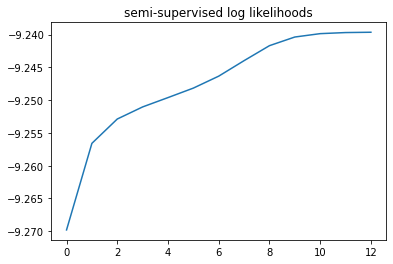

In [49]:
#Semi-Supervised Log_Likelihoods
print("total steps: ", len(s_loglikelihoods))
plt.plot(s_loglikelihoods)
plt.title("semi-supervised log likelihoods")
plt.show()

total steps:  1372


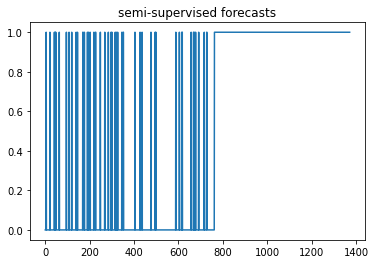

In [50]:
#Semi-supervised forecasts
print("total steps: ", len(s_forecasts))
plt.plot(s_forecasts)
plt.title("semi-supervised forecasts")
plt.show()

total steps:  1372


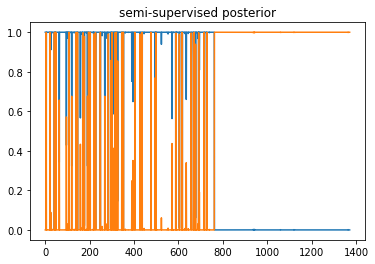

In [51]:
#Semi-supervised posterior 
print("total steps: ", len(s_posterior))
plt.plot(s_posterior)
plt.title("semi-supervised posterior")
plt.show()